In [1]:
# ---- Vertex reconstruction cartoon (clean version) --------------------------
# One canvas animation; parabolic tracks; hits only on fixed layers.
# Uses JS controls in notebooks: set animation.html to 'jshtml'.
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.colors import PowerNorm
from mpl_toolkits.mplot3d import art3d
from IPython.display import HTML
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.patches import Wedge

In [2]:
# ---------------------------------------------------------------------------
# Config
# ---------------------------------------------------------------------------
rng = np.random.default_rng(12)

R_LAYERS = np.array([2.5, 5.0, 12.5, 17.5])  # cm: fixed VTX radii where hits are allowed
N_TRACKS = 140                                # total tracks in the event
SIGMA_HIT = 0.045                             # cm: hit smear
SIGMA_WEIGHT = 0.06                           # cm: weight regularization
R_CONE = 5.30                                 # cartoon for R≈0.3 in η–φ (drawn in xy)
ZPLANE = -1.4                                 # where we paint the 2D projection plane (z value)
FIGSIZE = (8.6, 8.6)

# Cones: fixed at bottom-left area as requested; tracks are chosen to match these.
TARGET_CONES = np.array([
    [-4, -9],
    [-9, -4],
], dtype=float)


R_cone = 0.30             # Δη⊕Δφ radius (your “jet R”)
half_dphi = 0.30          # angular half-width shown in XY (≈ R)


In [3]:
# ---------------------------------------------------------------------------
# Helpers
# ---------------------------------------------------------------------------
def set_axes_tight_3d(ax, xs, ys, zs, pad=0.04, ortho=True, zoom=6):
    xmin, xmax = np.min(xs), np.max(xs)
    ymin, ymax = np.min(ys), np.max(ys)
    zmin, zmax = np.min(zs), np.max(zs)
    dx, dy, dz = xmax-xmin, ymax-ymin, zmax-zmin
    span = max(dx, dy, dz, 1e-6)
    cx, cy, cz = (xmax+xmin)/2, (ymax+ymin)/2, (zmax+zmin)/2
    ax.set_xlim(cx - span/2*(1+pad), cx + span/2*(1+pad))
    ax.set_ylim(cy - span/2*(1+pad), cy + span/2*(1+pad))
    ax.set_zlim(cz - span/2*(1+pad), cz + span/2*(1+pad))
    ax.set_box_aspect((1,1,1))
    if ortho:
        try: ax.set_proj_type('ortho')
        except Exception: pass
    ax.dist = zoom

def vertex_weight_map(X, Y, xy_hits, mask=None, sigma=SIGMA_WEIGHT):
    # Σ 1/sqrt(σ² + d²), vectorized over all hits
    if mask is not None:
        xy = xy_hits[~mask]
    else:
        xy = xy_hits
    # broadcast distance^2 over hits
    D2 = (X[..., None] - xy[:,0])**2 + (Y[..., None] - xy[:,1])**2
    return np.sum(1.0 / np.sqrt(sigma**2 + D2), axis=-1)

def in_cones(xy, centers, r=R_CONE):
    return np.logical_or(
        np.linalg.norm(xy - centers[0], axis=1) < r,
        np.linalg.norm(xy - centers[1], axis=1) < r
    )

def draw_cone_3d(ax, apex=(0,0,0), axis_phi=0.0, open_angle=0.3, height=6.0,
                 n_theta=40, color='magenta', alpha=0.25, edge_alpha=0.5):
    """
    Draw a single hollow cone (surface) with apex at 'apex', axis in XY at angle axis_phi,
    opening half-angle = open_angle (radians), longitudinal height = height.
    """
    # axis unit vector in XY, lift a tiny z to avoid degeneracy
    axdir = np.array([np.cos(axis_phi), np.sin(axis_phi), 0.0])
    # orthonormal basis around the axis
    # choose an up vector not parallel to axdir
    up = np.array([0,0,1.0])
    v = np.cross(axdir, up); v /= (np.linalg.norm(v)+1e-9)
    w = np.cross(axdir, v)

    # radius grows linearly: r(z) = z * tan(open_angle)
    zs = np.linspace(0, height, 2)
    rs = zs * np.tan(open_angle)

    # build a ring at z=height
    thetas = np.linspace(-open_angle, open_angle, n_theta)
    ring = []
    for th in thetas:
        # rotate away from axis within the cone’s azimuthal span
        dir_vec = (np.cos(th) * axdir) + (np.sin(th) * v)
        dir_vec /= (np.linalg.norm(dir_vec)+1e-9)
        P = np.array(apex) + axdir*zs[-1] + dir_vec*rs[-1]
        ring.append(P)

    # side surface (triangle fan)
    tris = []
    P_apex = np.array(apex)
    for i in range(len(ring)-1):
        tris.append([P_apex, ring[i], ring[i+1]])

    poly = Poly3DCollection(tris, facecolor=color, alpha=alpha, edgecolor=color, linewidths=0.6)
    ax.add_collection3d(poly)
    # draw the rim
    rim = np.array(ring)
    ax.plot(rim[:,0], rim[:,1], rim[:,2], color=color, alpha=edge_alpha, lw=2.0)
    return poly

def add_sector_xy(ax3d, center_xy, r_inner, r_outer, phi_center, half_span, color, z=0.0, alpha=0.25, ec=None, lw=2):
    """
    Draw a ring sector (annulus wedge) at z=z (using 2D Wedge lifted to 3D).
    Angles in radians; phi_center ± half_span define the sector.
    """
    deg0 = np.degrees(phi_center - half_span)
    deg1 = np.degrees(phi_center + half_span)
    # Outer wedge
    wedge = Wedge(center=tuple(center_xy), r=r_outer, theta1=deg0, theta2=deg1,
                  width=(r_outer - r_inner), color=color, alpha=alpha, ec=ec, lw=lw)
    ax3d.add_patch(wedge)
    art3d.pathpatch_2d_to_3d(wedge, z=z, zdir='z')
    return wedge

def draw_cone_edges(ax, apex, axis_phi, open_angle, height, color='magenta', lw=2, alpha=0.75):
    axdir = np.array([np.cos(axis_phi), np.sin(axis_phi), 0.0])  # axis in XY
    # a perpendicular in XY for the edges
    ortho = np.array([-np.sin(axis_phi), np.cos(axis_phi), 0.0])
    # edge directions (rotate ± open_angle around Z)
    e0 = (np.cos(open_angle)*axdir + np.sin(open_angle)*ortho)
    e1 = (np.cos(open_angle)*axdir - np.sin(open_angle)*ortho)
    A  = np.array([apex[0], apex[1], apex[2]])
    P0 = A + height*e0
    P1 = A + height*e1
    ax.plot([A[0], P0[0]], [A[1], P0[1]], [A[2], P0[2]], color=color, lw=lw, alpha=alpha)
    ax.plot([A[0], P1[0]], [A[1], P1[1]], [A[2], P1[2]], color=color, lw=lw, alpha=alpha)
    # rim arc
    ns = 100
    thetas = np.linspace(-open_angle, open_angle, ns)
    rim = np.array([A + height*(np.cos(t)*axdir + np.sin(t)*ortho) for t in thetas])
    ax.plot(rim[:,0], rim[:,1], rim[:,2], color=color, lw=lw, alpha=alpha)


In [4]:
# ---- dphi/deta helpers ------------------------------------------------------
def angdiff(a, b):
    # smallest signed angle difference in [-pi, pi]
    return (a - b + np.pi) % (2*np.pi) - np.pi

def eta_from_rz(r, z):
    # with z ≈ r*sinh(eta)  ->  eta = asinh(z/r)
    # handle r=0 gracefully
    r = np.asarray(r); z = np.asarray(z)
    return np.arcsinh(np.where(r > 0, z / np.maximum(r, 1e-9), 0.0))

def eta_from_dir(vec):
    # vec is a 3D direction; theta = arccos(z/|v|); eta = -ln(tan(theta/2))
    v = np.asarray(vec, float)
    v = v / (np.linalg.norm(v) + 1e-12)
    theta = np.arccos(np.clip(v[2], -1.0, 1.0))
    return -np.log(np.tan(0.5*theta))


In [5]:
import numpy as np
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

def _orthonormal_basis(a):
    """Given unit vector a, return two unit vectors n1,n2 ⟂ a (stable)."""
    a = a / (np.linalg.norm(a) + 1e-12)
    # pick a vector least aligned with a
    k = np.argmin(np.abs(a))
    tmp = np.zeros(3); tmp[k] = 1.0
    n1 = np.cross(a, tmp); n1 /= (np.linalg.norm(n1) + 1e-12)
    n2 = np.cross(a, n1);  n2 /= (np.linalg.norm(n2) + 1e-12)
    return a, n1, n2

def draw_cone_surface(ax, apex, axis_dir, half_angle, height,
                      n_az=48, n_h=16, face='magenta', edge='k',
                      face_alpha=0.18, edge_alpha=0.35, lw=0.6, show_axis=True):
    """
    Smooth conical surface around a true 3D axis.
    - apex: (x,y,z)
    - axis_dir: 3D vector giving axis direction (need not be unit)
    - half_angle: cone opening half-angle (radians)
    - height: length along the axis
    """
    a, n1, n2 = _orthonormal_basis(axis_dir)
    apex = np.asarray(apex, float)

    # coordinates on the cone
    hs = np.linspace(0.0, height, n_h)
    phis = np.linspace(0.0, 2*np.pi, n_az, endpoint=True)
    # radius grows linearly with h
    R = np.tan(half_angle) * hs  # shape (n_h,)

    # mesh
    X = []; Y = []; Z = []
    for h, r in zip(hs, R):
        ring = apex + h*a + (np.cos(phis)[:,None]*n1 + np.sin(phis)[:,None]*n2) * r
        X.append(ring[:,0]); Y.append(ring[:,1]); Z.append(ring[:,2])
    X = np.array(X); Y = np.array(Y); Z = np.array(Z)

    # surface
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                           linewidth=0, antialiased=True,
                           shade=True, alpha=face_alpha, color=face)

    # light wireframe to “read” the cone
    wf = ax.plot_wireframe(X, Y, Z, rstride=max(1, n_h//4), cstride=max(1, n_az//12),
                           linewidth=lw, color=edge, alpha=edge_alpha)

    # rim circle at the end
    xr, yr, zr = X[-1], Y[-1], Z[-1]
    ax.plot(xr, yr, zr, color=edge, alpha=max(edge_alpha, 0.5), lw=lw+0.3)

    # axis guideline
    if show_axis:
        tip = apex + height*a
        ax.plot([apex[0], tip[0]], [apex[1], tip[1]], [apex[2], tip[2]],
                color=face, lw=2.0, alpha=0.75)

    return surf, wf


In [6]:
# ---------------------------------------------------------------------------
# Synthetic event with parabolic tracks and layer-only hits
#   - Tracks are defined by an azimuth φ and a small parabolic z(r)=a r^2 + b r
#   - XY positions sit ONLY on the fixed radii R_LAYERS.
# ---------------------------------------------------------------------------
true_vtx = np.array([0.0, 0.0, 0.0])  # place at origin for clarity

phis = rng.uniform(0, 2*np.pi, size=N_TRACKS)
# Parabola coeffs: small curvature; a and b vary per track
a_coeff = rng.normal(0.010, 0.004, size=N_TRACKS)    # z ~ O(cm) over 20 cm
b_coeff = rng.normal(0.02,  0.02,  size=N_TRACKS)

# Build ideal (unsmeared) hit positions per track and then smear
hits_list = []
track_id = []
for i in range(N_TRACKS):
    phi = phis[i]
    a, b = a_coeff[i], b_coeff[i]
    for R in R_LAYERS:
        x = R * np.cos(phi)
        y = R * np.sin(phi)
        z = a*R*R + b*R
        hits_list.append([x, y, z])
        track_id.append(i)
hits = np.array(hits_list, dtype=float)
labels = np.array(track_id, dtype=int)


# Smear hits (detector resolution)
hits += rng.normal(0.0, SIGMA_HIT, size=hits.shape)

# Convenience views
hits_xy = hits[:, :2]
hits_z  = hits[:, 2]

In [7]:
# ---------------------------------------------------------------------------
# Synthetic event with η-driven tracks and layer-only hits
#   - XY hits only on fixed radii R_LAYERS
#   - z(r) = z0 + r*sinh(η) (+ tiny curvature)  → realistic pseudorapidity spread
# ---------------------------------------------------------------------------
true_vtx = np.array([0.0, 0.0, 0.0])  # origin for clarity

# mid-rapidity Au+Au: flat-ish core in |η|≤1 with Gaussian tails
def sample_eta(n, eta_flat=1.0, tail_sigma=1.2, tail_frac=0.35, max_abs=3.5):
    m = int(n * (1 - tail_frac))
    k = n - m
    flat  = rng.uniform(-eta_flat, eta_flat, size=m)
    tails = rng.normal(0.0, tail_sigma, size=k)
    eta   = np.concatenate([flat, tails])
    eta   = np.clip(eta, -max_abs, max_abs)
    rng.shuffle(eta)
    return eta

etas = sample_eta(N_TRACKS)
phis = rng.uniform(0, 2*np.pi, size=N_TRACKS)

# small vertex-z spread and tiny r^2 curvature so lines aren’t perfectly straight
z0_per_track = rng.normal(0.0, 0.08, size=N_TRACKS)        # cm
kappa_z      = rng.normal(0.0008, 0.0004, size=N_TRACKS)   # cm^{-1}

hits_list, track_id = [], []
for i in range(N_TRACKS):
    phi  = phis[i]
    eta  = etas[i]
    z0   = z0_per_track[i]
    kap  = kappa_z[i]
    for R in R_LAYERS:
        x = R*np.cos(phi)
        y = R*np.sin(phi)
        z = z0 + R*np.sinh(eta) + kap*(R**2)  # <-- η geometry
        hits_list.append([x, y, z])
        track_id.append(i)

hits   = np.array(hits_list, dtype=float)
labels = np.array(track_id, dtype=int)

# detector resolution
hits += rng.normal(0.0, SIGMA_HIT, size=hits.shape)

# convenience views
hits_xy = hits[:, :2]
hits_z  = hits[:, 2]


In [8]:
# ---------------------------------------------------------------------------
# Choose two candidate tracks that best match your target cones (at layer R=17.5)
# ---------------------------------------------------------------------------
# last-layer points for each track (largest R)
last_xy = []
for i in range(N_TRACKS):
    # take the hit with max radius for this track:
    sel = np.where(labels == i)[0]
    h = hits[sel]
    idx_maxR = np.argmax(np.hypot(h[:,0], h[:,1]))
    last_xy.append(h[idx_maxR, :2])
last_xy = np.vstack(last_xy)

cand_idx = []
for tc in TARGET_CONES:
    d = np.linalg.norm(last_xy - tc, axis=1)
    choice = int(np.argmin(d))
    if choice in cand_idx:
        # take next closest if duplicate
        order = np.argsort(d)
        for alt in order:
            if int(alt) not in cand_idx:
                choice = int(alt); break
    cand_idx.append(choice)
cand_idx = np.array(cand_idx, dtype=int)

cone_centers = TARGET_CONES.copy()  # cones exactly at requested positions

In [9]:
# vertex at origin in the clean notebook; change if yours differs:
vtx_xy = np.array([0.0, 0.0])

# direction (azimuth) for each candidate = vector from vertex to last-layer hit
def track_axis_phi(idx):
    sel = np.where(labels == idx)[0]
    pts = hits[sel]
    # pick the largest-radius hit for direction
    j = np.argmax(np.hypot(pts[:,0], pts[:,1]))
    d = pts[j,:2] - vtx_xy
    return np.arctan2(d[1], d[0])

phi_axes = np.array([track_axis_phi(cand_idx[0]),
                     track_axis_phi(cand_idx[1])])

R_cone = 0.30             # Δη⊕Δφ radius (your “jet R”)
half_dphi = 0.30          # angular half-width shown in XY (≈ R)
r_in, r_out = 0.0, 18.5   # radial extent of the sector in XY (to just past outer layer)


In [10]:
def track_axis_3d(idx):
    sel = np.where(labels == idx)[0]
    pts = hits[sel]
    # order by radius so last two are the largest-R layers
    r = np.hypot(pts[:,0], pts[:,1]); order = np.argsort(r)
    pts = pts[order]
    if len(pts) >= 2:
        v = pts[-1] - pts[-2]          # direction tail -> end (includes z slope)
    else:
        v = pts[-1] - np.array([0,0,0])
    return v / (np.linalg.norm(v) + 1e-12)

axis3d = np.array([track_axis_3d(cand_idx[0]),
                   track_axis_3d(cand_idx[1])])


In [11]:
# per-hit azimuth & pseudorapidity
r_hit   = np.hypot(hits[:,0], hits[:,1])
phi_hit = np.arctan2(hits[:,1], hits[:,0])
eta_hit = eta_from_rz(r_hit, hits[:,2])

# per-axis azimuth & pseudorapidity
phi_axes = np.array([np.arctan2(axis3d[0][1], axis3d[0][0]),
                     np.arctan2(axis3d[1][1], axis3d[1][0])])

eta_axes = np.array([eta_from_dir(axis3d[0]),
                     eta_from_dir(axis3d[1])])

# boolean selections: pass BOTH |Δφ|<half_dphi AND |Δη|<DELTA_ETA_CUT
dphi0 = np.abs(angdiff(phi_hit, phi_axes[0]))
dphi1 = np.abs(angdiff(phi_hit, phi_axes[1]))
deta0 = np.abs(eta_hit - eta_axes[0])
deta1 = np.abs(eta_hit - eta_axes[1])

sel_red0 = (dphi0**2 + deta0**2) <= R_cone**2
sel_red1 = (dphi1**2 + deta0**2) <= R_cone**2
sel_red  = sel_red0 | sel_red1   # hits that satisfy BOTH cuts for either jet


In [12]:
# ---------------------------------------------------------------------------
# Tracklets: short segments built from (layer i) → (layer i+1) hits, with extras
# from candidate tracks so they visibly flow into the cones.
# ---------------------------------------------------------------------------
def build_tracklets_from_layers(hits, labels, emphasize_idx=(), extras_per_cand=30):
    lets = []
    # build per-track ordered by radius
    for i in range(N_TRACKS):
        sel = np.where(labels == i)[0]
        pts = hits[sel]
        r   = np.hypot(pts[:,0], pts[:,1])
        order = np.argsort(r)
        pts = pts[order]
        # make small segments between consecutive layers
        for j in range(len(pts)-1):
            lets.append(pts[j:j+2])  # 2-point segment is fine
    # add some extra segments from candidate tails (toward cones)
    for t in emphasize_idx:
        sel = np.where(labels == t)[0]
        pts = hits[sel]
        r   = np.hypot(pts[:,0], pts[:,1])
        order = np.argsort(r)
        pts = pts[order]
        tail = pts[-3:] if len(pts) >= 3 else pts
        for _ in range(extras_per_cand):
            if len(tail) >= 2:
                k = rng.choice(len(tail)-1, size=1)[0]
                lets.append(tail[k:k+2])
    return lets

tracklets = build_tracklets_from_layers(hits, labels, emphasize_idx=cand_idx, extras_per_cand=40)


In [13]:
# Leftover tracklets = segments whose both endpoints are outside cones
def segment_outside_cones(seg, centers, r=R_CONE):
    return (np.linalg.norm(seg[:, :2] - centers[0], axis=1) >= r).all() and \
           (np.linalg.norm(seg[:, :2] - centers[1], axis=1) >= r).all()

tracklets_left = [seg for seg in tracklets if segment_outside_cones(seg, cone_centers)]

# Mask for deselection
mask_in_cone = in_cones(hits_xy, cone_centers, R_CONE)

# ---------------------------------------------------------------------------
# Vertex weight grids (for two hypotheses to show the peak)
# ---------------------------------------------------------------------------
x = np.linspace(-1.8, 1.8, 200)
y = np.linspace(-1.8, 1.8, 200)
X, Y = np.meshgrid(x, y)

# Hypothesis A at origin (true vertex), Hypothesis B mildly shifted
true_xy = np.array([0.0, 0.0])
alt_xy  = np.array([-0.35, -0.20])

Z0 = vertex_weight_map(X, Y, hits_xy, mask=mask_in_cone, sigma=SIGMA_WEIGHT)             # around true
Z1 = vertex_weight_map(X, Y, hits_xy - (alt_xy-true_xy), mask=mask_in_cone, sigma=SIGMA_WEIGHT)  # shifted map


In [14]:
# ---------------------------------------------------------------------------
# Animation on ONE 3D canvas: 3D → top-down projection (no axes replacement)
# ---------------------------------------------------------------------------
def setup_3d(ax):
    ax.view_init(elev=28, azim=225)
    ax.set_xlabel('x (cm)'); ax.set_ylabel('y (cm)'); ax.set_zlabel('z (cm)')

def setup_topdown(ax):
    ax.view_init(elev=90, azim=0)
    ax.set_zticks([])
    ax.zaxis.pane.set_alpha(0)

def draw_density_plane(ax, X, Y, Z, norm=None, cmap='viridis', alpha=0.92, z=ZPLANE):
    if norm is None:
        vmin, vmax = np.nanpercentile(Z, 5), np.nanmax(Z)
        norm = plt.Normalize(vmin, vmax)
    C = plt.get_cmap(cmap)(norm(Z))
    return ax.plot_surface(X, Y, np.full_like(Z, z), facecolors=C,
                           rstride=1, cstride=1, linewidth=0, antialiased=False,
                           shade=False, alpha=alpha)

def draw_tracklets(ax, lets, color='C2', lw=1.2, alpha=0.8, z_is_3d=True, max_n=None):
    lines = []
    L = lets if max_n is None else lets[:max_n]
    for seg in L:
        if z_is_3d:
            ln, = ax.plot(seg[:,0], seg[:,1], seg[:,2], color=color, lw=lw, alpha=alpha)
        else:
            ln, = ax.plot(seg[:,0], seg[:,1], [ZPLANE]*len(seg), color=color, lw=lw, alpha=alpha)
        lines.append(ln)
    return lines

# Precompute coordinate arrays for tight framing (include cones & tracklets)
all_x = np.concatenate([hits[:,0], *[seg[:,0] for seg in tracklets], cone_centers[:,0]])
all_y = np.concatenate([hits[:,1], *[seg[:,1] for seg in tracklets], cone_centers[:,1]])
all_z = np.concatenate([hits[:,2], *[seg[:,2] for seg in tracklets], np.full(len(cone_centers), ZPLANE)])

# Frame legend text
step_titles = [
    "3D hits on fixed VTX layers",
    "Add short tracklets (between layers)",
    "Highlight two tracks of interest",
    "Place two jet cones (R≈0.3)",
    "Deselect hits inside cones",
    "Project leftover hits & tracklets to XY",
    "Shift vertex hypothesis & select different tracklets",
    "Vertex weight map peaks at (x,y)",
]


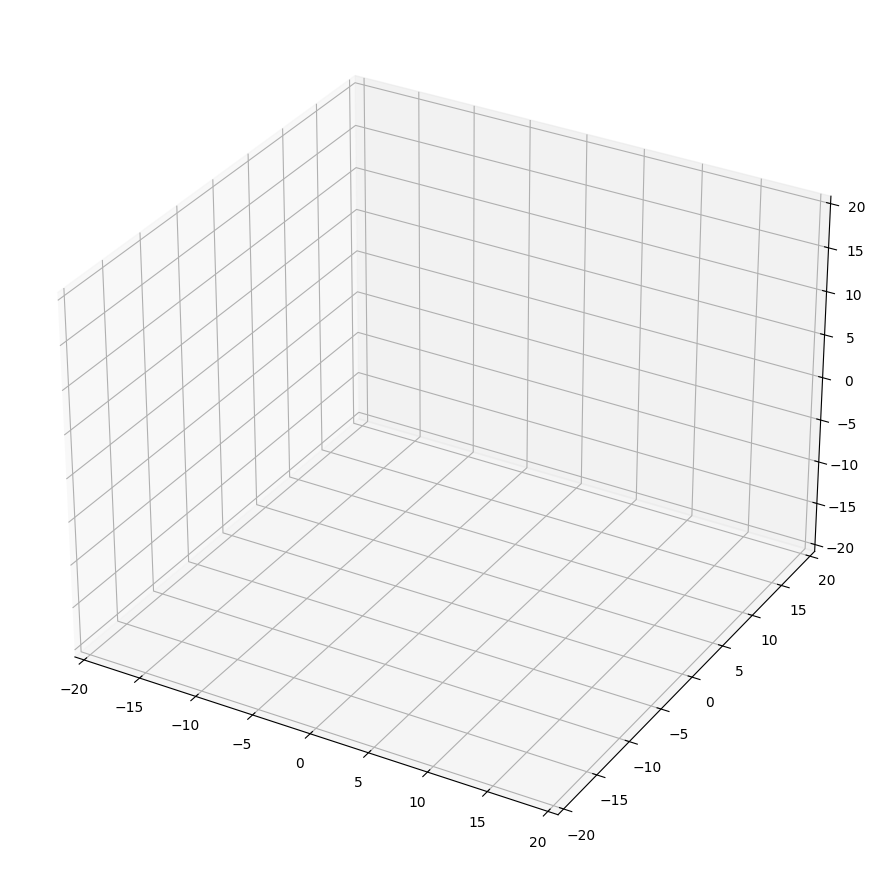

In [15]:

fig = plt.figure(figsize=FIGSIZE)
ax  = fig.add_subplot(111, projection='3d')
ax.set_xlim(-20, 20)
ax.set_ylim(-20, 20)
ax.set_zlim(-20, 20)

fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
title = plt.title("")

In [16]:
def animate(f):
    ax.cla()
    if f <= 4:
        # --- 3D stage ---
        setup_3d(ax)
        # hits
        # all hits (gray)
        ax.scatter(hits[:,0], hits[:,1], hits[:,2], s=10, alpha=0.45, color='k')

        ## Δφ & Δη selected hits (red, on top)
        #ax.scatter(hits[sel_red,0], hits[sel_red,1], hits[sel_red,2],
        #           s=16, alpha=0.95, color='red', edgecolor='k', linewidth=0.3, zorder=6)

        # tracklets
        if f >= 1:
            draw_tracklets(ax, tracklets, color='C2', lw=1.1, alpha=0.75, z_is_3d=True, max_n=280)
        # two candidate tracks (draw by connecting their layer hits)
        if f >= 2:
            for idx, col in zip(cand_idx, ('magenta','orange')):
                sel = np.where(labels == idx)[0]
                pts = hits[sel]
                r   = np.hypot(pts[:,0], pts[:,1])
                order = np.argsort(r)
                pts = pts[order]
                ax.plot(pts[:,0], pts[:,1], pts[:,2], color=col, lw=2.8)
        # cones (always on ZPLANE so they also show in projection)
        if f >= 3:
            apex = (0.0, 0.0, 0.0)  # your vertex position; change if not at origin
            # half-angle ~ jet R in radians; for your sectors you used half_dphi
            ha = half_dphi
            # height along the axis (tweak to taste)
            hlen = 14.0

            draw_cone_surface(ax, apex, axis3d[0], ha, hlen,
                              face='magenta', edge='k', face_alpha=0.16, edge_alpha=0.35)
            draw_cone_surface(ax, apex, axis3d[1], ha, hlen,
                              face='orange',  edge='k', face_alpha=0.16, edge_alpha=0.35)


    else:
        # --- top-down projection on the same 3D axes ---
        setup_topdown(ax)
        # deselected (ghost) vs kept (solid) hits on plane
        # still inside animate(f), projection phase
        # projection phase (2D on ZPLANE)
        if f >= 4:
            add_sector_xy(ax, vtx_xy, r_in, r_out, phi_axes[0], half_dphi,
                          color='magenta', z=ZPLANE, alpha=0.22)
            add_sector_xy(ax, vtx_xy, r_in, r_out, phi_axes[1], half_dphi,
                          color='orange',  z=ZPLANE, alpha=0.22)
            # --- draw hits on the XY plane (bring them back) ---
            # ghost the deselected (inside sectors), highlight the kept
        ax.scatter(hits[:,0], hits[:,1], s=10, alpha=0.3, color='k')
        # Δφ & Δη selected hits (red, on top)
        ax.scatter(hits[sel_red,0], hits[sel_red,1], hits[sel_red,2],
                   s=26, alpha=0.95, color='red', edgecolor='k', linewidth=0.3, zorder=6)

        
        # leftover tracklets in 2D
        if f >= 5:
            draw_tracklets(ax, tracklets_left, color='C2', lw=1.2, alpha=0.9, z_is_3d=False, max_n=240)
        # current vertex hypothesis
        v = alt_xy if f >= 6 else true_xy
        ax.scatter([v[0]],[v[1]],[ZPLANE], s=90, facecolor='none', edgecolor='cyan', lw=2.2)
        # cones
        # density plane
        if f >= 7:
            Zmap = Z1 if f >= 6 else Z0
            norm = PowerNorm(gamma=0.5, vmin=np.nanpercentile(Z0,5), vmax=np.nanmax(Z0))
            draw_density_plane(ax, X, Y, Zmap, norm=norm, cmap='viridis', alpha=0.92, z=ZPLANE)
            ax.contour(X, Y, Zmap, zdir='z', offset=ZPLANE, colors='w', linewidths=0.65, levels=10, alpha=0.85)
        set_axes_tight_3d(ax, all_x, all_y, np.full_like(all_x, ZPLANE), pad=0.01, ortho=True, zoom=6)

    title.set_text(f"Au+Au vertex reconstruction — {step_titles[f]}")
    ax.set_xlim(-20, 20)
    ax.set_ylim(-20, 20)
    ax.set_zlim(-20, 20)

    return []

In [ ]:

ani = FuncAnimation(fig, animate, frames=8, interval=1100, blit=False, repeat_delay=800)

if False:
    ani.save('output/vertex_reco/vertex_reco.gif', writer='pillow', fps=1000//700)

plt.close(fig)
HTML(ani.to_jshtml(default_mode='loop'))

In [ ]:
if False:
    ! ffmpeg -i output/vertex_reco/vertex_reco.gif -vsync 0 output/vertex_reco/vertex_reco_%03d.png

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab